## Описание решения

Совсем по-простому задачу можно решить используя метод одного ближайшего соседа (1-Nearest Neighbor) — попиксельно сравнить новое изображение со всеми изображениями из датасета, выбрать самое похожее и поставить новому тот же класс.

Метод ближайший соседа делается быстро и просто, но работать оно будет очень так себе. Решил сделать посложнее.

Результаты:
1. Реализована подготовка и обработка датасета
2. Выбрана и написана нейросеть 
3. Подготовлен демонстрационный микро-сервис


### Подготовка датасета

Для пайплайна использовал новенькую библиотеку Torch Data. Раньше с ней не работал, но выглядит она многообещающе. Библиотека, в целом, оправдала ожидания — удобная и потенциально очень шустрая.

В качестве аугументаций использовал [TrivialAugument](https://arxiv.org/abs/2103.10158) — авторы обещают хорошее качество из коробки вообще без тюнинга.

![augemntations.png](assets/augemntations.png)

В реальной задаче стоило бы сделать датасет сбалансированным и попробовать разные аугументации.

### Нейросеть (Siamese neural net)

За основу взял архитектуру [Siamese neural net](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf). Она не самая новая, но довольно хорошо изучена и показывает неплохие результаты для аналогичных задач.

![Siamese neural net.png](assets/Siamese%20neural%20net.png)

Основная идея — вложить каждое изображение в пространство эмбеддингов таким образом, чтобы похожие объекты имели близкие эмбеддинги, а не похожие - далекие эмбеддинги. 

В качестве функции потерь взята [contrastive loss](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), которая использовалась авторами архитектуры.

На обучение не стал время тратить, сетка будет работать с дефолтными весами для демонстрационных целей. Мороженое будет распозноваться не очень. При желании можно докрутить.

Еще надо подумать, как стоит модифицировать выходной слой, чтобы на выходе выдавать что-то более интерпретируемое, чем эмбеддинги. Например, вероятность или что-нибудь похожее. Сейчас по пороговому значению делается выбор «ванильный/не ванильный пломбир», это просто, но не самое наглядное решение.

При сбалансированном датасете (его можно таким сделать) для метрики качества можно использовать обычную точность (accuracy).

### Микро-сервис

Для тестового задания я использовал фреймворк Gradio, он удобен и позволяет быстро демонстрировать возможности нейросетки. 

Для реальной задачи я бы делал рестовый АПИ на FastAPI, который позволяет быстро обрабатывать запросы, имеет встроенную поддержку асинхронности, автоматическую генерацию интерактивной документации и простот в масштабировании.



![microservice.png](assets/microservice.png)


### Примечания

Для наглядности все реализовано в одном питоновской тетрадке, хотя кода довольно много. По-хорошему бы это надо разбить на модули.

## Решение

### Подготовка окружения

```
# production
python3.10 -m pip install torch torchvision torchdata gradio

# dev
python3.10 -m pip install matplotlib
```

### Конфиг и общие импорты

In [11]:
import PIL
import torch
import torchdata.datapipes as dp
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch import nn
import torch.nn.functional as F
import gradio as gr


from pathlib import Path

IMAGE_SIZE = (192, 128)  # H x W
AUGUMENT_NUM = 32
BATCH_SIZE = 32
DATASET_FOLDER = "test-data"
NUM_WORKERS = 4
EPOCHS = 5
MARGIN = 2.0
THRESHOLD = 1

torch.manual_seed(42)

### Подготовка датасета

In [2]:
def label_sample(file_path: str | Path) -> dict:
    name = Path(file_path).stem

    target_icecream = name in ["9", "10"]
    label = 1 if target_icecream else 0

    return {"label": label, "file_path": file_path}


def read_image(file_path: str | Path) -> PIL.Image:
    return PIL.Image.open(file_path)


def augument_sample(sample: dict) -> list:
    augumenter = T.TrivialAugmentWide()

    aug_samples = []
    for _ in range(AUGUMENT_NUM):
        new_sample = sample.copy()
        new_sample["image"] = augumenter(new_sample["image"])
        aug_samples.append(new_sample)

    return aug_samples


def icecream_dataset(folder_path: str) -> dp.iter.IterDataPipe:
    datapipe = dp.iter.FileLister(folder_path)
    datapipe = datapipe.map(label_sample)
    datapipe = datapipe.map(read_image, input_col="file_path", output_col="image")

    resize = T.Resize(IMAGE_SIZE, antialias=True)
    datapipe = datapipe.map(resize, input_col="image")

    # TODO: make the dataset balanced
    datapipe = datapipe.flatmap(augument_sample)

    datapipe = datapipe.map(TF.to_tensor, input_col="image")
    datapipe = datapipe.shuffle().sharding_filter().batch(2, drop_last=True)

    # TODO: add custom collate function

    return datapipe

In [3]:
import matplotlib.pyplot as plt
from itertools import chain


def plot_images_in_row(dataset: list, display_number: int = 30):
    samples = chain.from_iterable(dataset)
    images = [TF.to_pil_image(sample["image"]) for sample in samples]
    images = images[:display_number]

    num_images = len(images)
    fig, ax = plt.subplots(1, display_number, figsize=(30, 8))

    for i, image in enumerate(images):
        ax[i].imshow(image)
        ax[i].axis("off")

    plt.show()

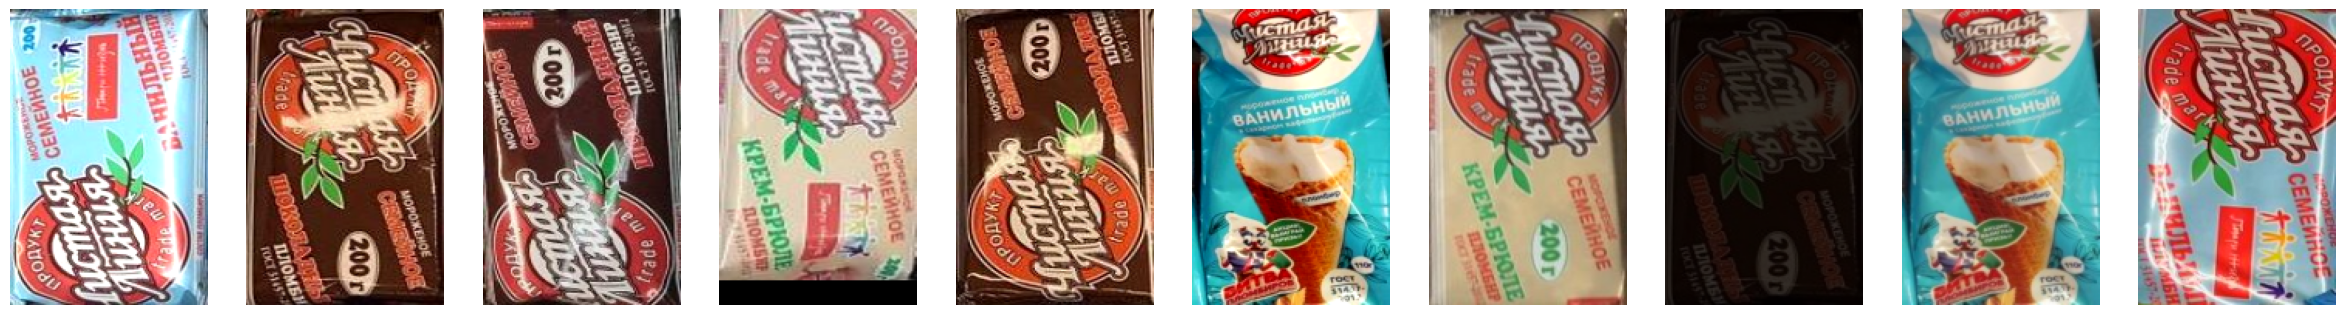

In [4]:
# Test
dataset = icecream_dataset(DATASET_FOLDER)
plot_images_in_row(dataset, 10)

### Нейросеть (Siamese neural net)

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_chans: int, out_chans: int, kernel: int = 3, stride: int = 1):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_chans,
                out_channels=out_chans,
                kernel_size=kernel,
                stride=stride,
                bias=False,
            ),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(out_chans),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class SiameseIceCreamNet(nn.Module):
    def __init__(
        self, image_height: int = 192, image_width: int = 128, in_chans: int = 3
    ):
        super().__init__()
        self.image_height = image_height
        self.image_width = image_width

        self.conv_block = nn.Sequential(
            ConvBlock(in_chans, out_chans=64, stride=2),
            ConvBlock(in_chans=64, out_chans=128),
            ConvBlock(in_chans=128, out_chans=128),
        )

        self.fc = nn.Sequential(
            nn.Linear(in_features=7680, out_features=2048),
            nn.GELU(),
            nn.Linear(in_features=2048, out_features=1024),
        )

    def forward_once(self, x: torch.Tensor) -> torch.Tensor:
        # x.shape : [BN, C, H, W]
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def forward(
        self, x1: torch.Tensor, x2: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        x1 = self.forward_once(x1)
        x2 = self.forward_once(x2)

        return x1, x2

In [6]:
# Test
net = SiameseIceCreamNet()

pair = next(iter(dataset))
x1, x2 = pair[0]["image"].unsqueeze(0), pair[1]["image"].unsqueeze(0)

net(x1, x2)[0].shape

torch.Size([1, 1024])

#### Функиця потерь

In [7]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin: float):
        super().__init__()
        self.margin = margin

    def forward(
        self, x1: torch.Tensor, x2: torch.Tensor, y: torch.Tensor
    ) -> torch.Tensor:
        # x.shape -> [BN, OUT_FEATURES]
        # y.shape -> [1, BN]
        # x1 is similar to x2 -> y = 0
        # x1 is dissimilar to x2 -> y = 1

        distance = F.pairwise_distance(x1, x2, keepdim=True)

        loss = (1 - y) @ torch.pow(distance, 2) + y @ torch.pow(
            torch.clamp(self.margin - distance, min=0.0), 2
        )
        loss = loss * 1 / 2

        return loss

In [8]:
# Test
loss_function = ContrastiveLoss(MARGIN)

loss_function(2 * torch.ones(5, 10), 5 * torch.ones(5, 10), torch.zeros(1, 5))

tensor([[224.9998]])

### Обучение модели

In [9]:
# TODO: train model and display metrics

### Микро-сервис

In [13]:
def prepare_image(image: PIL.Image) -> torch.Tensor:
    image = TF.resize(image, size=IMAGE_SIZE, antialias=True)
    image = TF.to_tensor(image).unsqueeze(0)

    return image


def predict(image: PIL.Image) -> str:
    image = prepare_image(image)
    x1, x2 = net(original_image, image)

    distance = F.pairwise_distance(x1, x2) / 2 ** (1 / 2)
    similar_images = distance < THRESHOLD

    label = (
        "Пломбир Ванильный 200гр Флоу-пак (Семейное)"
        if similar_images
        else "Другое мороженое"
    )
    return label


net = SiameseIceCreamNet()
original_image = read_image("test-data/9.jpg")
original_image = prepare_image(original_image)


demo = gr.Interface(fn=predict, inputs="pil", outputs=gr.Label())
demo.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
